In [6]:
import numpy as np
import numba

R =  0.1
L =  0.01
K_p = 0.1
T_pi = 0.1
struct = np.rec.array([(np.zeros((2,1)),
                        np.zeros((2,1)),
                        R,
                        L,
                        100.0,
                        K_p,
                        T_pi,
                        10.0
                        )],
                       dtype=[('x', np.float64,(2,1)),
                              ('f', np.float64,(2,1)),
                              ('R', np.float64),
                              ('L', np.float64),
                              ('v', np.float64),
                              ('K_p', np.float64),
                              ('T_pi', np.float64),
                              ('i_ref', np.float64)
                             ])

In [7]:
@numba.njit(cache=True)
def f_eval(struct):
    L = struct[0].L
    R = struct[0].R
    K_p = struct[0].K_p
    T_pi = struct[0].T_pi
    i_ref = struct[0].i_ref
    
    i_l = struct[0].x[0,0]
    xi = struct[0].x[1,0]
    
    error = i_ref - i_l
    v = K_p*(error + 1.0/T_pi*xi)
    
    struct[0].f[0,0] =  1.0/L*(v - R*i_l)
    struct[0].f[1,0] =  error
    
    struct[0].v = v

In [8]:
@numba.njit(cache=True)
def solver(struct):
    x_0 = 0.0
    Dt = 1.0e-3
    N_steps = 10000
    N_states = 2
    N_outs = 1
    T = np.zeros(N_steps)
    X = np.zeros((N_steps,N_states))
    Y = np.zeros((N_steps,N_outs))
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0,0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        
        # euler solver
        f_eval(struct)
        struct[0].x[:,0] += Dt*struct[0].f[:,0]
        
        # channels
        T[it+1] = t
        X[it+1,0] = struct[0].x[0,0]   
        X[it+1,1] = struct[0].x[1,0]  
        Y[it+1,0] = struct[0].v
        
    return T,X,Y

# with hyper: 1.42 ms ± 9.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# without hyper: 1.41 ms ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [11]:
%timeit T,X,Y = solver(struct)
T,X,Y = solver(struct)

1.41 ms ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Output plot

<IPython.core.display.Javascript object>


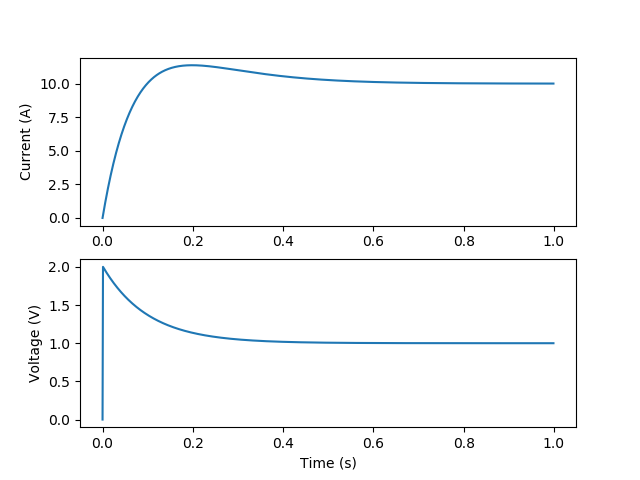

In [53]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('')

fig, (ax0,ax1) = plt.subplots(nrows=2)   # creates a figure with one axe
ax0.plot(T,X[:,0])
ax1.plot(T,Y[:,0])

#ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
plt.show()

In [54]:
@numba.njit(cache=True)
def solver_trapz(struct):
    x_0 = 0.0
    Dt = 1.0e-3
    N_steps = 10000
    N_states = 2
    N_outs = 1
    T = np.zeros(N_steps)
    X = np.zeros((N_steps,N_states))
    Y = np.zeros((N_steps,N_outs))
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0,0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        
        f_eval(struct)
        x_left = np.copy(struct[0].x[:,0])
        f_left = np.copy(struct[0].f[:,0])
        struct[0].x[:,0] = x_left + Dt * f_left
        f_eval(struct)
        struct[0].x[:,0] = x_left + 0.5*Dt*(f_left + struct[0].f[:,0])
        
        
        # channels
        T[it+1] = t
        X[it+1,0] = struct[0].x[0,0]   
        X[it+1,1] = struct[0].x[1,0]  
        Y[it+1,0] = struct[0].v
        
        
    return T,X,Y



In [56]:
%timeit T_trapz,X_trapz, Y_trapz = solver_trapz(struct)
T_trapz,X_trapz,Y_trapz = solver_trapz(struct)

3.55 ms ± 5.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:

def exact(T):
    return   1000 * (1- np.exp(-T*R/L))

<IPython.core.display.Javascript object>


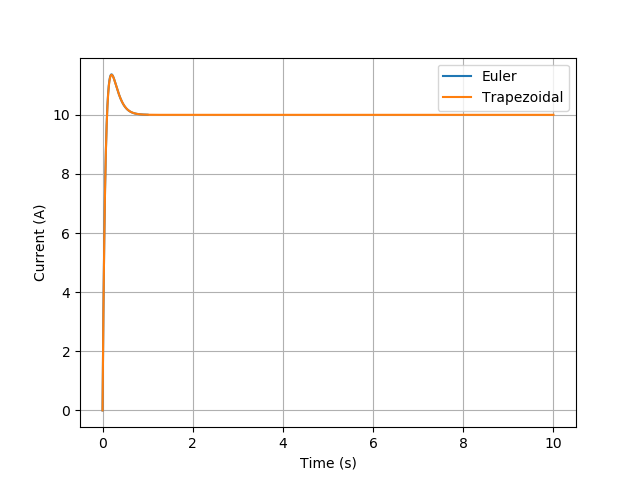

In [61]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('')

fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe
#ax0.plot(T_trapz,exact(T_trapz), label='Exact')
ax0.plot(T,X[:,0], label='Euler')
ax0.plot(T_trapz,X_trapz[:,0], label='Trapezoidal')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
ax0.grid()
ax0.legend()
plt.show()

<IPython.core.display.Javascript object>


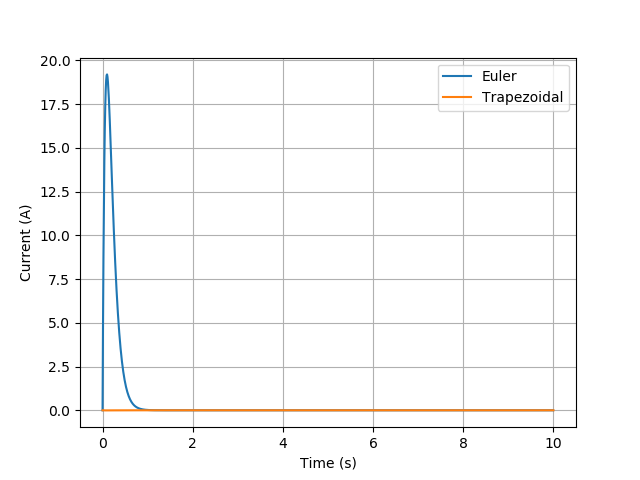

In [27]:
fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe

ax0.plot(T,X-exact(T), label='Euler')
ax0.plot(T_trapz,X_trapz[:,0] - exact(T_trapz), label='Trapezoidal')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
ax0.grid()
ax0.legend()
plt.show()